This tutorial uses the same example as the [example introduction](../example_introduction.ipynb).
In other words:

In [1]:
# Module we will use
import chaospy
import numpy
from matplotlib import pyplot

def model_predictor(coordinates, parameters):
    """Over simplistic model function."""
    param_I, param_a = parameters
    return param_I*numpy.e**(-param_a*coordinates)

# The spatio-temporal coordinates 
coordinates = numpy.linspace(0, 10, 1000)

# The distribution of the parameters
distribution_I = chaospy.Normal(1.5, 0.2)
distribution_a = chaospy.Uniform(0.1, 0.2)
distribution = chaospy.J(distribution_I, distribution_a)

## Lagrange Polynomials

[Lagrange polynomials](https://en.wikipedia.org/wiki/Lagrange_polynomial) are not a method for creating orthogonal polynomials.
Instead it is an interpolation method for creating an polynomial expansion that has the property that each polynomial interpolates exactly one point in space with the value 1 and has the value 0 for all other interpolation values.

In [2]:
samples = distribution.sample(10, rule="halton")
samples[:, :5]

array([[1.26993012, 1.56372787, 1.43627213, 1.73006988, 1.19317589],
       [0.14444444, 0.17777778, 0.12222222, 0.15555556, 0.18888889]])

In [3]:
polynomial_expansion = chaospy.lagrange_polynomial(samples)
polynomial_expansion[0].round(2)

polynomial(143.72+2445.4*q1-15721.24*q1**2+21527.76*q1**3-503.51*q0-214.38*q0*q1+4287.25*q0*q1**2+332.38*q0**2-362.8*q0**2*q1-58.19*q0**3)

In [4]:
polynomial_expansion(*samples).round(8)

array([[ 1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0.,  1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0.,  1., -0., -0., -0., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -0., -0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  1.]])

Fitting the polynomials to the evaluations does not need to involve regression.
Instead it is enough to just multiply the lagrange polynomial expansion with the evaluations, and sum it up:

In [5]:
model_evaluations = numpy.array([model_predictor(coordinates, sample) for sample in samples.T])
model_approximation = chaospy.sum(model_evaluations.T*polynomial_expansion, axis=-1).T
model_approximation.shape

(1000,)

The results is close to what we are used to from the other methods:

[0, 10, 0, 2]

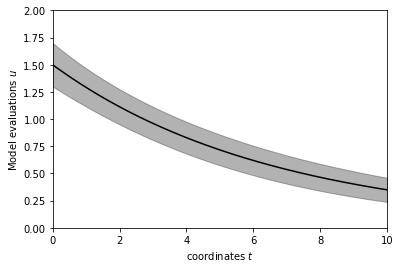

In [6]:
# Estimate mean and variance
expected = chaospy.E(model_approximation, distribution)
variance = chaospy.Var(model_approximation, distribution)

# Create band one standard deviation away from mean 
pyplot.fill_between(coordinates, expected-variance**0.5, expected+variance**0.5,
                        alpha=0.3, color="k", label="standard deviation")
pyplot.plot(coordinates, expected, "k-", label="Estimated expected value")

# Make plot pretty
pyplot.xlabel("coordinates $t$")
pyplot.ylabel("Model evaluations $u$")
pyplot.axis([0, 10, 0, 2])